# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Get all the Data, Build all the Graphs

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
science_repo_sql = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                    --science 
                    SELECT
                    	repo_git, ntile(10) over ( order by commits_all_time) 
                    FROM
                    	repo A,
                    	(
                    	SELECT C.repo_id, d.commits_all_time
                    	FROM
                    		augur_operations.users A,
                    		augur_operations.user_groups b,
                    		augur_operations.user_repos C, 
                    		api_get_all_repos_commits d 
                    	WHERE
                    		A.user_id = b.user_id 
                    		AND b.group_id = C.group_id 
                    		AND d.repo_id= c.repo_id
                    		AND b.NAME = 'science' --AND lower(A.login_name)='numfocus'
                    		
                    	ORDER BY
                    		A.login_name,
                    		d.commits_all_time,
                    		b.group_id 
                    	) b 
                    WHERE
                    	A.repo_id = b.repo_id order by commits_all_time desc
                            """)

with engine.connect() as conn:
    #df = pd.read_sql(sql, cnxn)
    results = conn.execute(science_repo_sql)
    df_results = pd.DataFrame(results) 

print(df_results)

                                               repo_git  ntile
0           https://github.com/rstudio/gcc-darwin-arm64     10
1           https://github.com/rstudio/vscode-workbench     10
2                        https://github.com/rails/rails     10
3                         https://github.com/jabref/jdk     10
4               https://github.com/lockss/lockss-daemon     10
...                                                 ...    ...
1904         https://github.com/bioconductor/uidaho2017      1
1905               https://github.com/rails/hide_action      1
1906            https://github.com/ropensci/weatherdata      1
1907             https://github.com/dspace/xmlui-webapp      1
1908  https://github.com/lockss/lockss-integration-t...      1

[1909 rows x 2 columns]


Graphs for NTILE: 1
contributor graph: Nodes as projects, edges as contributors
Graphs for NTILE: 2


KeyboardInterrupt: 

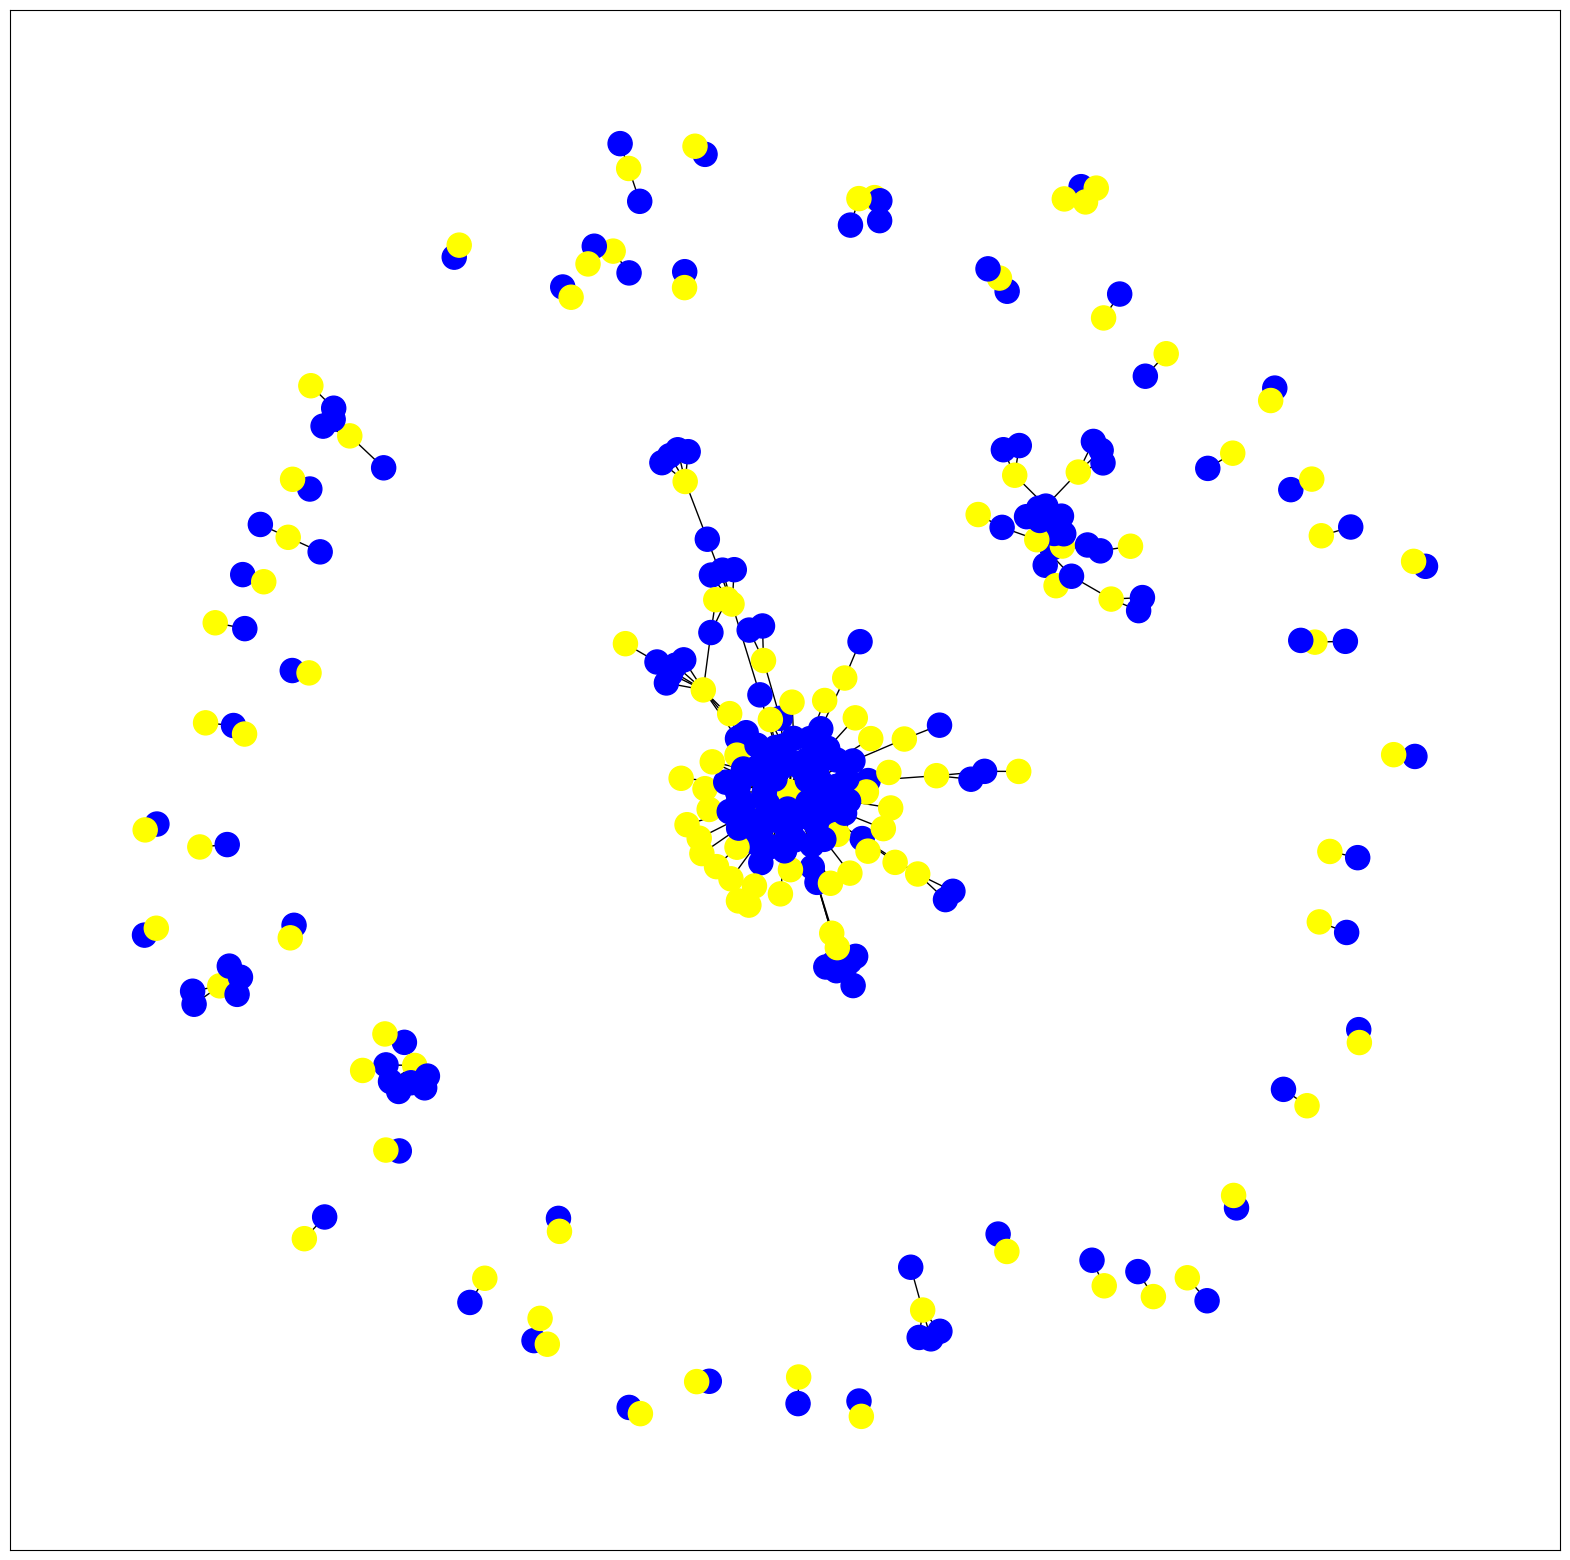

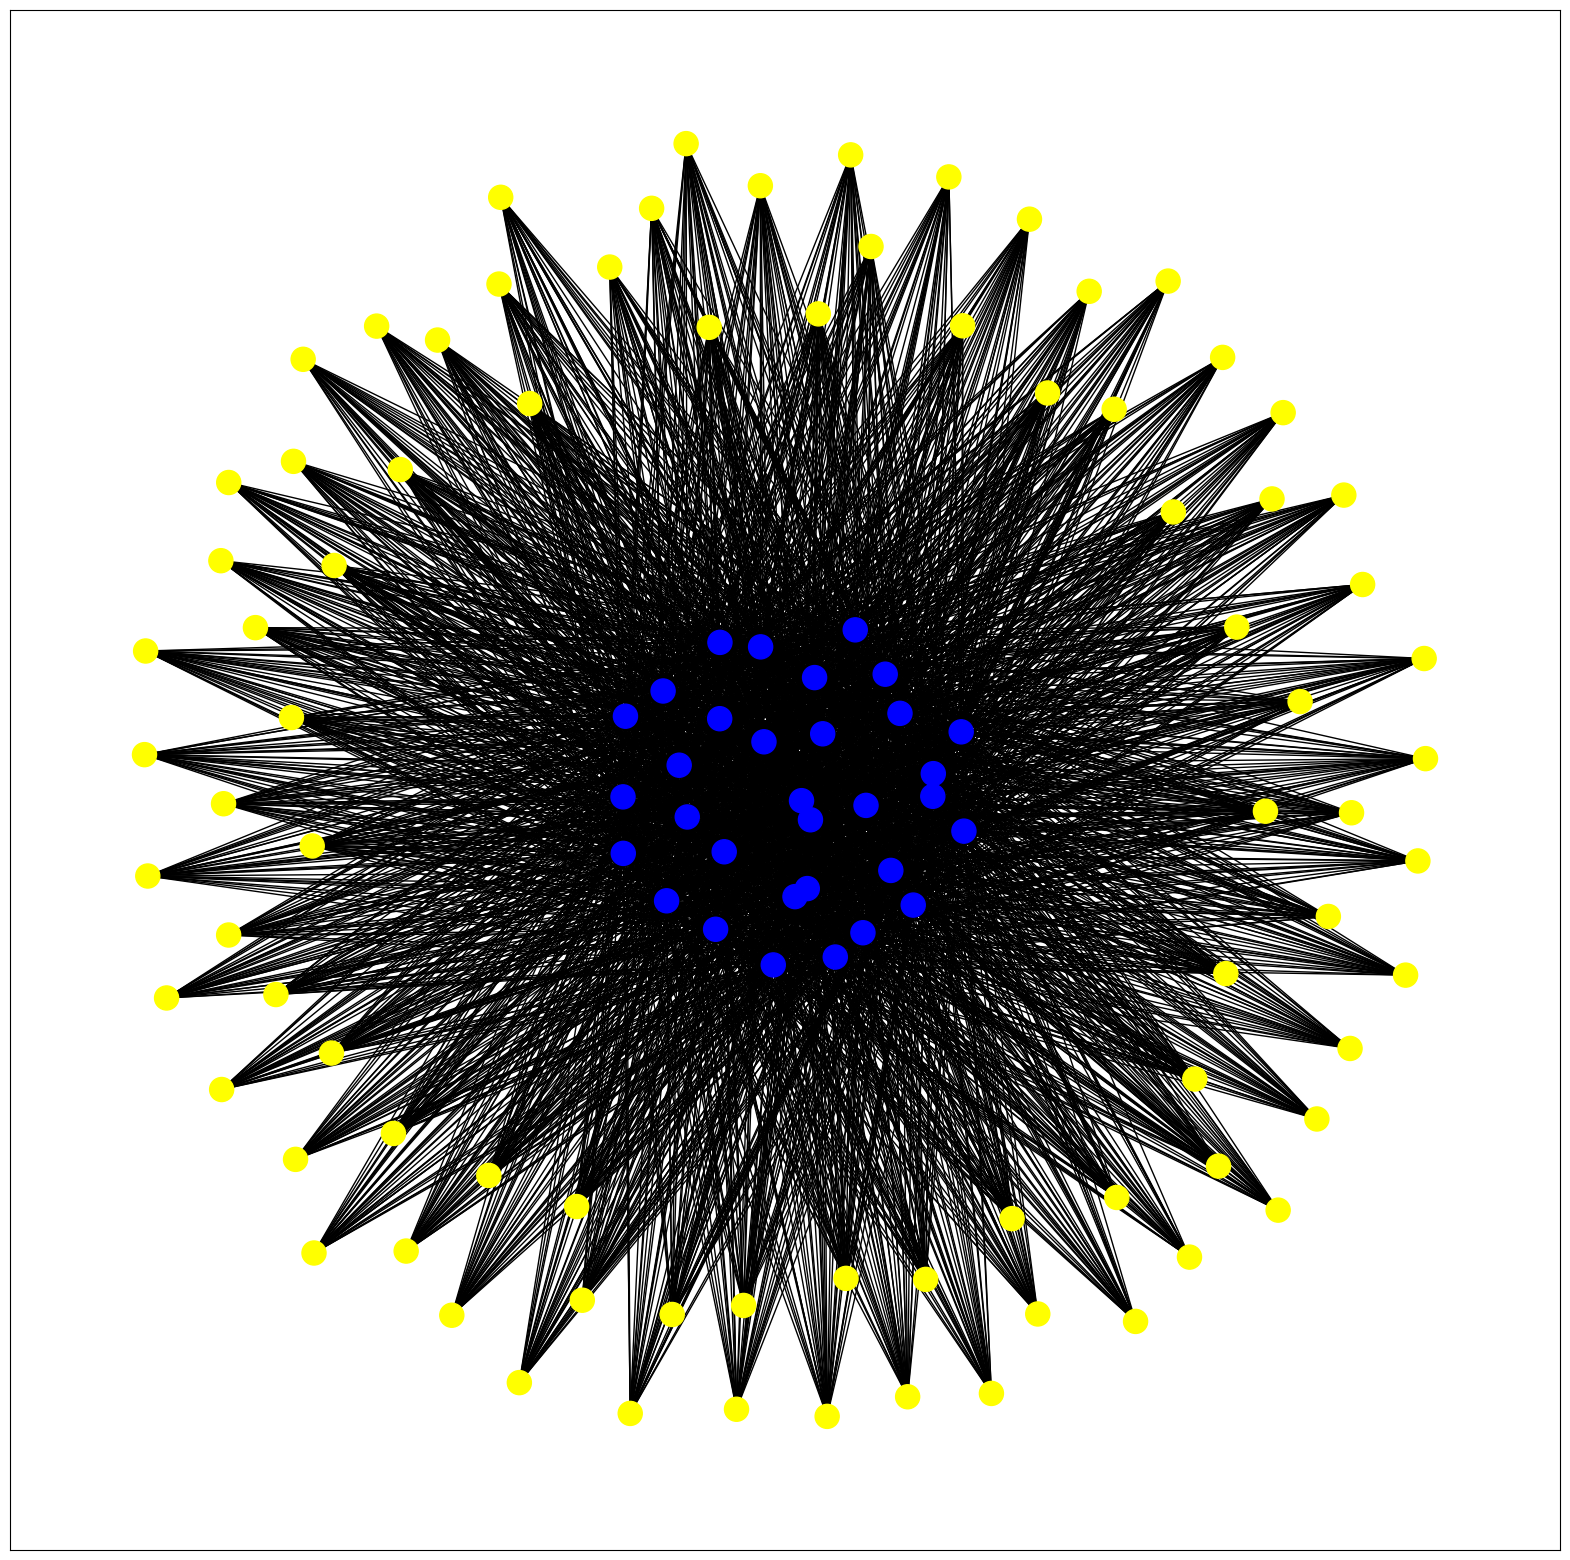

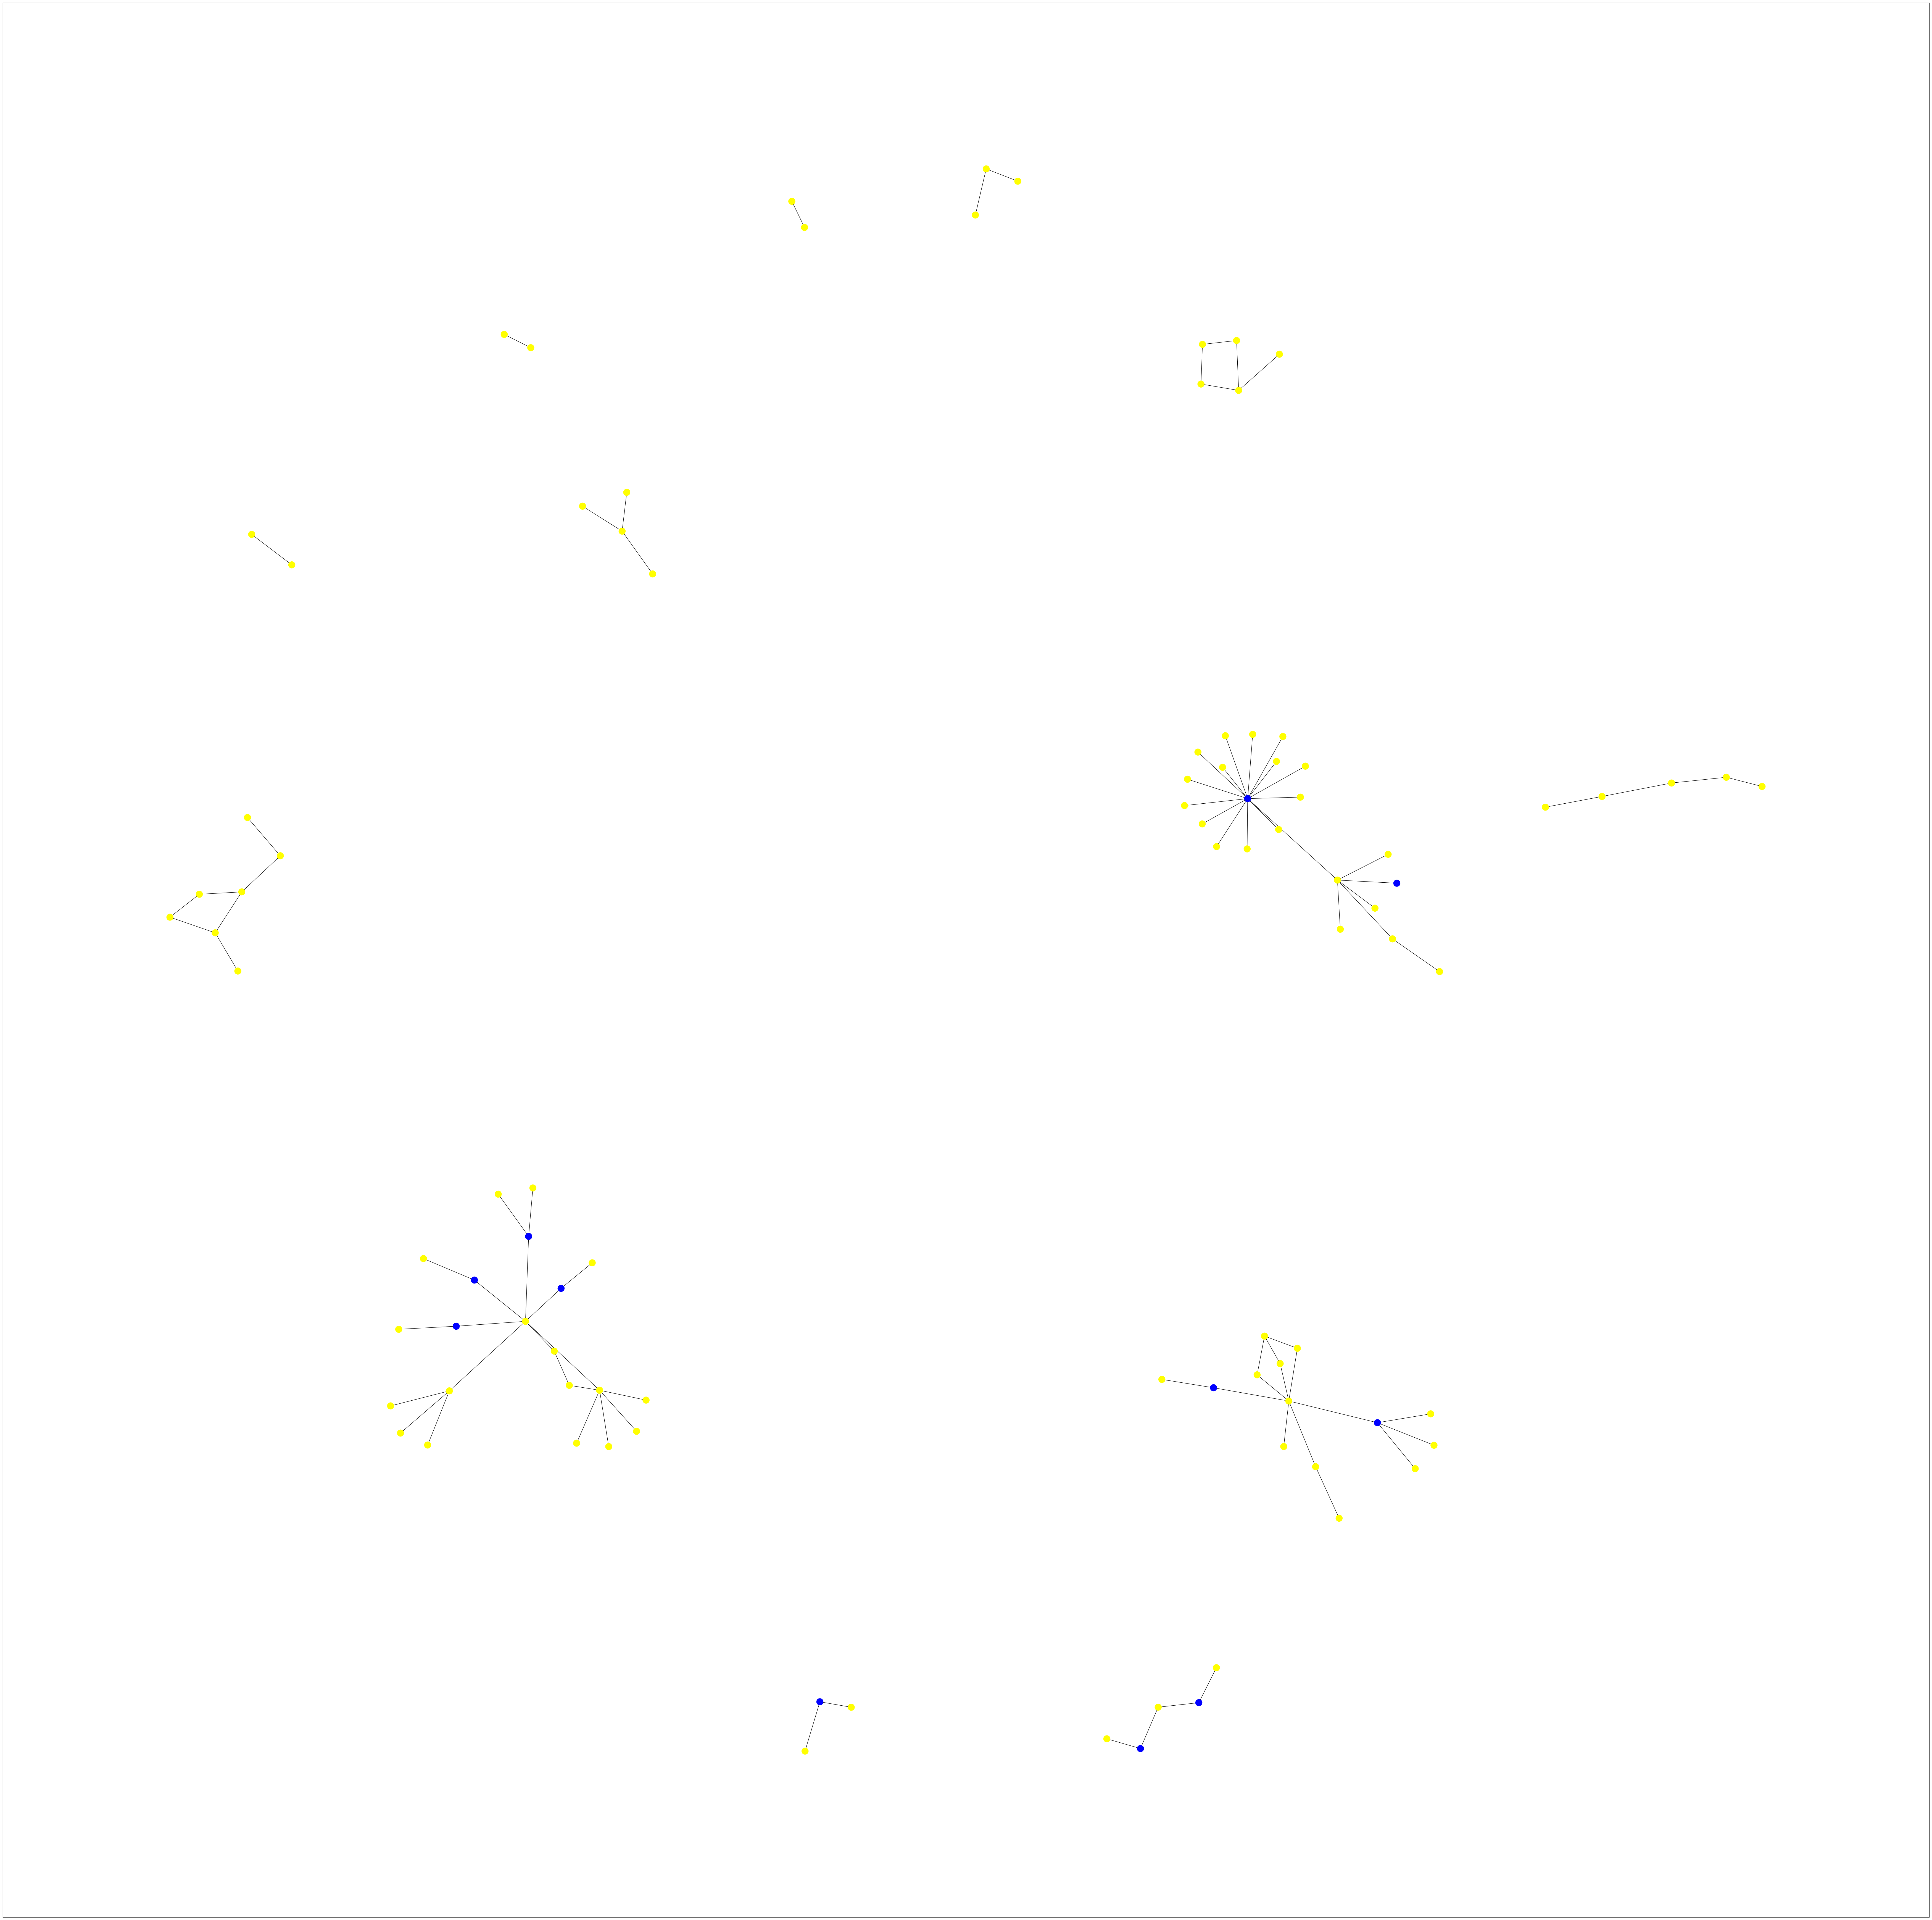

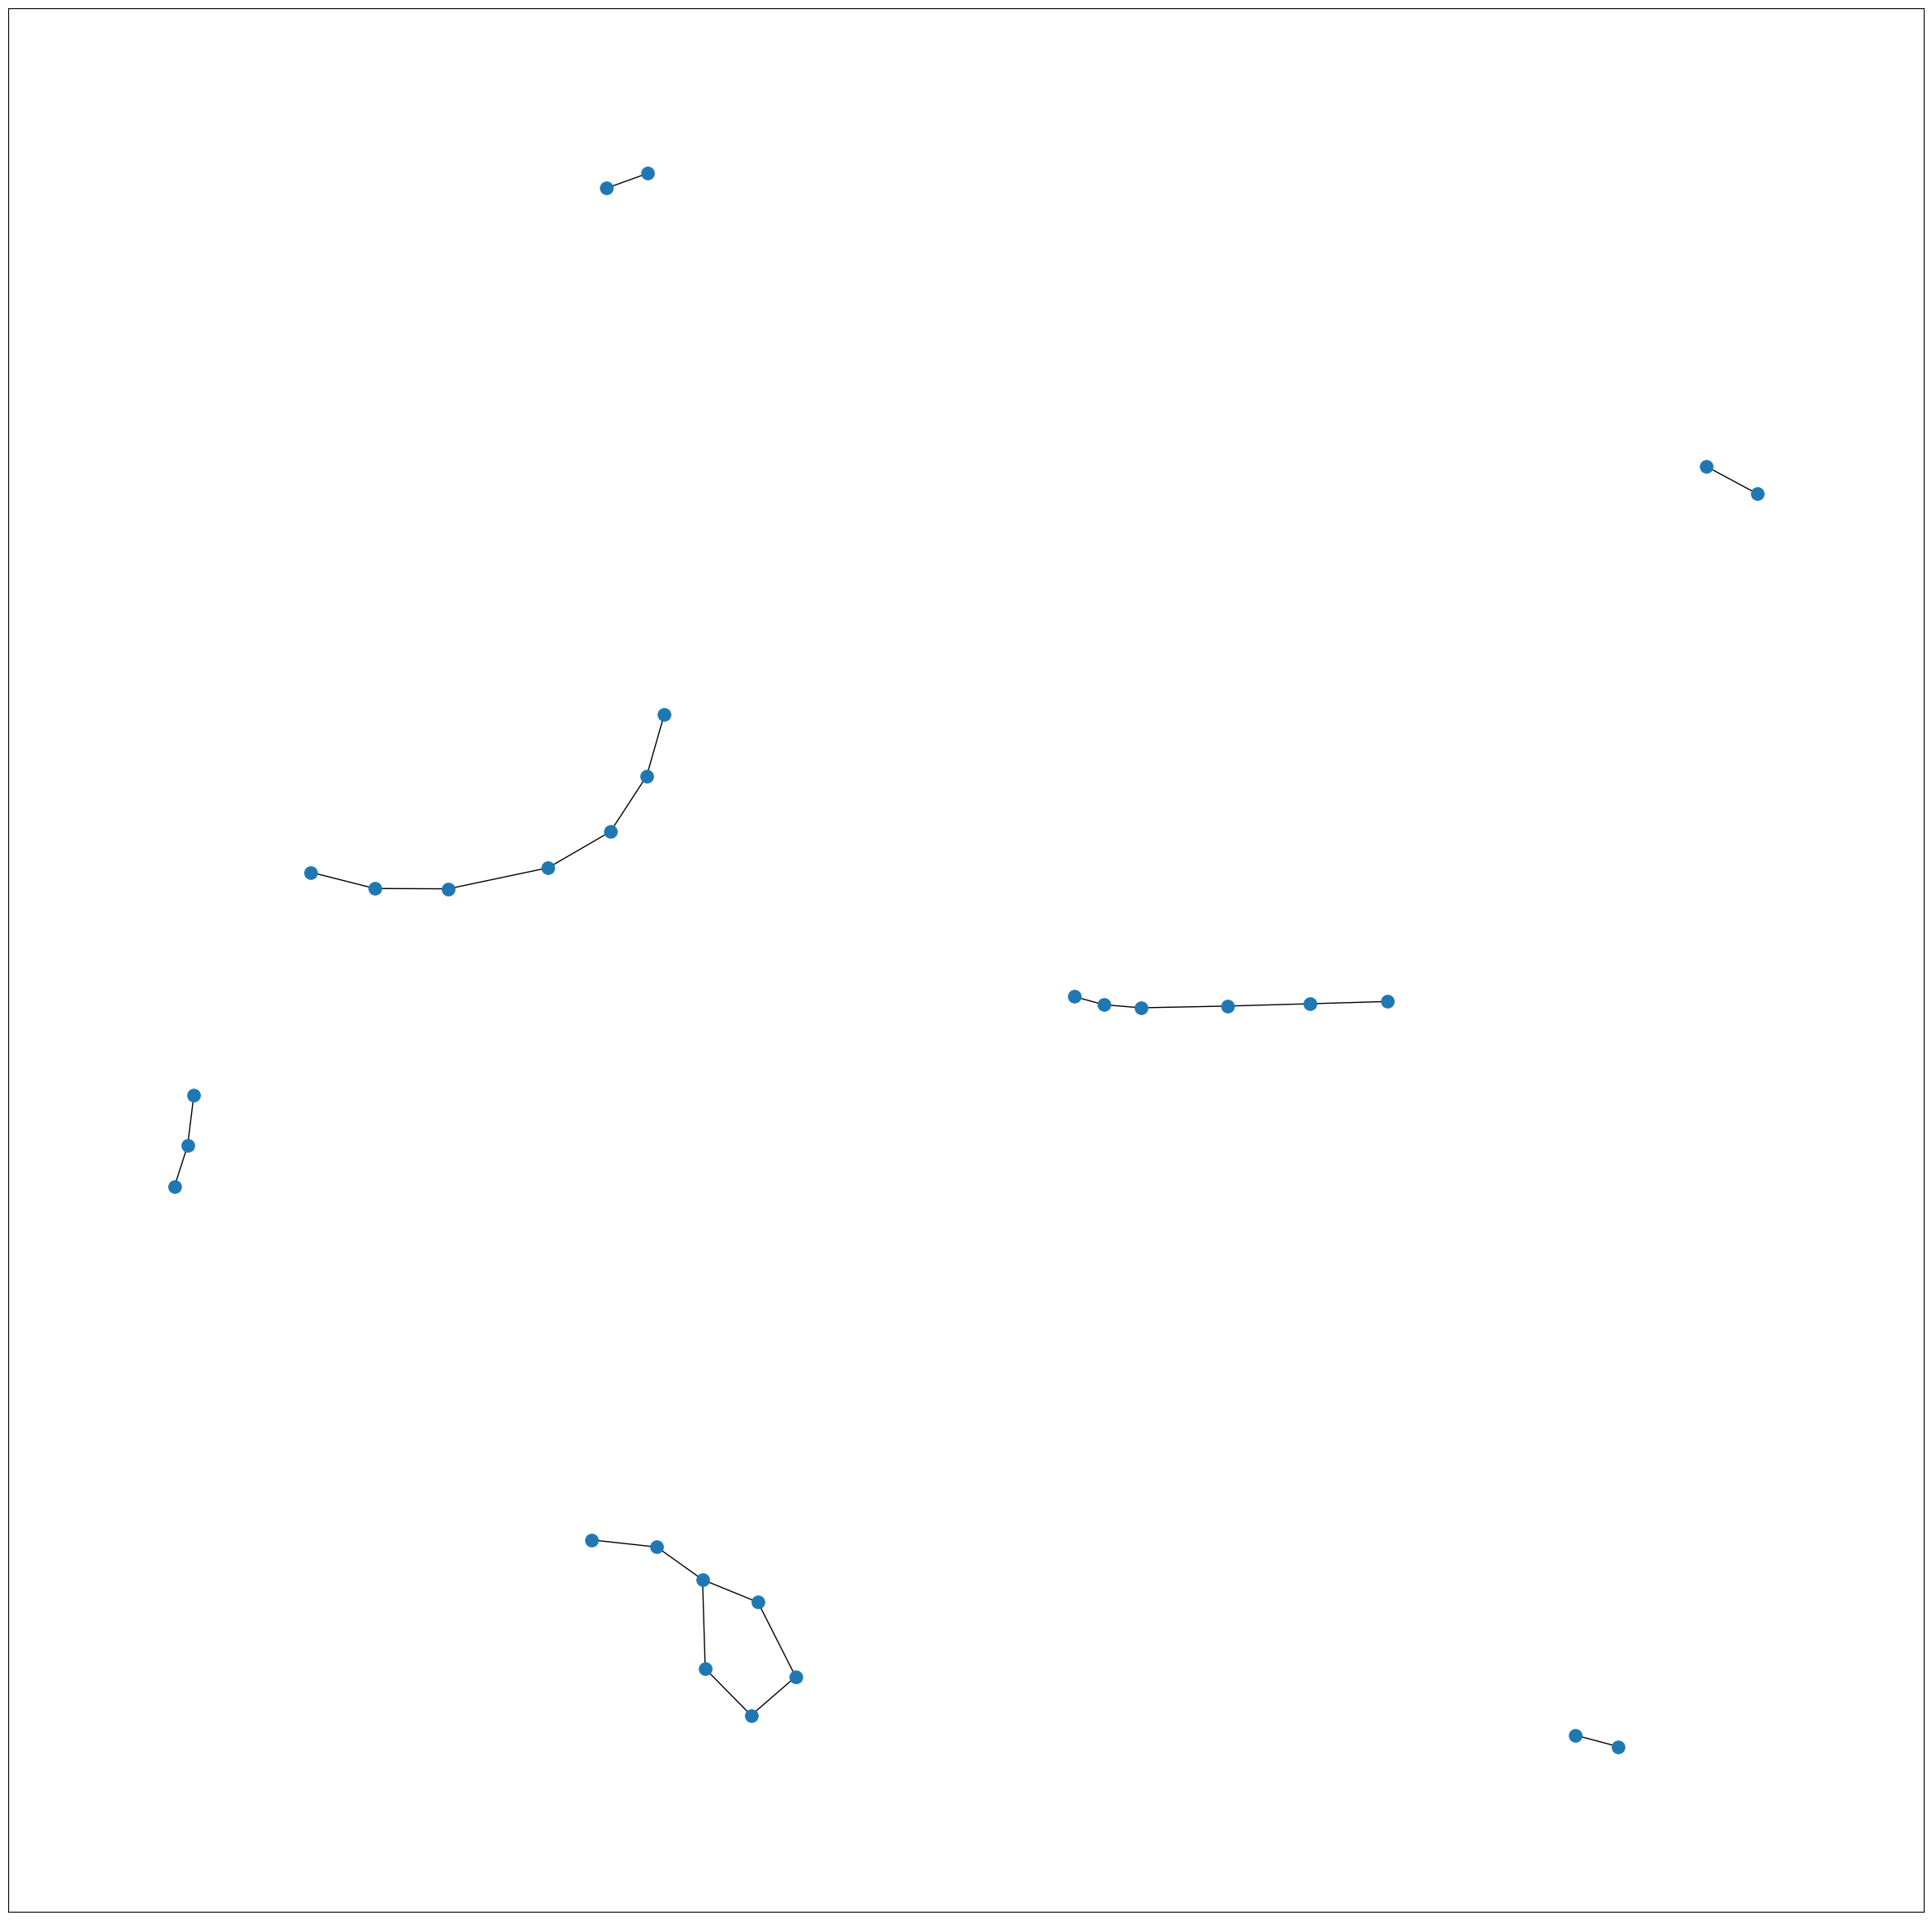

In [4]:
#find unique ntile values
ntiles = df_results.ntile.unique()

#sort values smallest to largest
ntiles.sort()

#display sorted values
ntiles

#run analysis in ntiles
#surveys_df[surveys_df.year == 2002]

for i in ntiles:
    repo_set=[]
    repo_git_set = []
    repo_name_set = []
    result_tile = df_results[df_results.ntile==i]
    #print(i)
    #print(result_tile)

    
    print("Graphs for NTILE: " + str(i))


    for index, row in result_tile.iterrows():
        trepo_git=row["repo_git"]
        repo_query = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                     SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{trepo_git}'
            """)
        with engine.connect() as conn:
            results = conn.execute(repo_query)
            df2_results = pd.DataFrame(results) 
        df2_results.reset_index(drop=True, inplace=True) 
        repo_id = int(df2_results['repo_id'].values)
        repo_name = df2_results['repo_name'].to_string(index=False)
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)
        repo_git_set.append(trepo_git)    

        #Issue Contributors
        issue_contrib = pd.DataFrame()
        for repo_id in repo_set:
            repo_query = salc.sql.text(f"""
                        SET SCHEMA 'augur_data';
                        SELECT r.repo_id,
                        r.repo_git,
                        i.reporter_id as cntrb_id,
                        i.issue_id
                        FROM
                        repo r, issues i
                         WHERE
                        i.repo_id = {repo_id} AND
                        i.repo_id = r.repo_id
                """)
            df_current_repo = pd.read_sql(repo_query, con=engine)
            issue_contrib = pd.concat([issue_contrib, df_current_repo])
        
        issue_contrib = issue_contrib.reset_index()
        issue_contrib.drop("index", axis=1, inplace=True)
        issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
        #display(issue_contrib)
        #issue_contrib.dtypes    
    
        #PR Contributors
        pr_contrib = pd.DataFrame()
        
        for repo_id in repo_set:
            repo_query = salc.sql.text(f"""
                        SET SCHEMA 'augur_data';
                        SELECT r.repo_id,
                        r.repo_git,
                        prm.cntrb_id,
                        prm.pull_request_id
                        FROM
                        repo r, pull_request_meta prm
                        WHERE
                        prm.repo_id = {repo_id} AND
                        prm.repo_id = r.repo_id
                """)
            df_current_repo = pd.read_sql(repo_query, con=engine)
            pr_contrib = pd.concat([pr_contrib, df_current_repo])
        
        pr_contrib = pr_contrib.reset_index()
        pr_contrib.drop("index", axis=1, inplace=True)
        pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
        #display(pr_contrib)
        #pr_contrib.dtypes
    
        #PR Reviewers
        prr_contrib = pd.DataFrame()
        
        for repo_id in repo_set:
            repo_query = salc.sql.text(f"""
                        SET SCHEMA 'augur_data';
                        SELECT r.repo_id,
                        r.repo_git,
                        prr.cntrb_id,
                        prr.pull_request_id
                        FROM
                        repo r, pull_request_reviews prr
                        WHERE
                        prr.repo_id = {repo_id} AND
                        prr.repo_id = r.repo_id
                """)
            df_current_repo = pd.read_sql(repo_query, con=engine)
            prr_contrib = pd.concat([prr_contrib, df_current_repo])
        
        pr_contrib = pr_contrib.reset_index()
        pr_contrib.drop("index", axis=1, inplace=True)
        prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
        #display(prr_contrib)
        #prr_contrib.dtypes
    
        # Commit Contributors
        commit_contrib = pd.DataFrame()
        
        for repo_id in repo_set:
            repo_query = salc.sql.text(f"""
                        SET SCHEMA 'augur_data';
                        SELECT r.repo_id,
                        r.repo_git,
                        ca.cntrb_id,
                        c.cmt_id
                        FROM
                        repo r, commits c, contributors_aliases ca
                        WHERE
                        c.repo_id = {repo_id} AND
                        c.repo_id = r.repo_id and
                        c.cmt_committer_email = ca.alias_email
                """)
            df_current_repo = pd.read_sql(repo_query, con=engine)
            commit_contrib = pd.concat([commit_contrib, df_current_repo])
        
        commit_contrib = commit_contrib.reset_index()
        commit_contrib.drop("index", axis=1, inplace=True)
        commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
        #display(commit_contrib)
        #commit_contrib.dtypes

###########################################################################
        
    # Commit Contributor Graph
    df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_commit.head()
    df_commit = df_commit.reset_index()
    
    df_melted_commit = df_commit.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')
    
    df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
    df_melted_commit.head()
    G = nx.from_pandas_edgelist(df_melted_commit, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    Repo_id = df_melted_commit['repo_id'].to_list()
    contributor_id = df_melted_commit['cntrb_id'].to_list()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    #yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
    #blue_patch = mpatches.Patch(color='blue', label='Repository')
    #ax.legend(handles=[yellow_patch, blue_patch])
    nx.draw_networkx(G, node_color=colors, with_labels=False, font_size=8, ax=ax)

    # Issue Contributor Graph
    df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_issue = df_issue.reset_index()
    df_melted_issue = df_issue.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_issue, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]
    fig, ax = plt.subplots(figsize=(20,20))
    #ax.legend(handles=[yellow_patch, blue_patch])
    nx.draw_networkx(G, node_color=colors, with_labels=False,  font_size=8, ax=ax)


    ### PR Contributor Graph
    df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_pr = df_pr.reset_index()
    df_melted_pr = df_pr.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_pr, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())

    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(90,90))
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw_networkx(G, node_color=colors, with_labels=False, font_size=8, ax=ax)

    ## Nodes as projects edges as contributors
    #  In this section, we represent data differently and try out another graph representation where the project repositories are represented by nodes, and the edges are shared contributions between those projects

    print('contributor graph: Nodes as projects, edges as contributors')
    #    print(`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".)
    #**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
    #We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
    #This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

    #structure of `contributorGraph` =  
       # {  
       # `repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
       # `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
       # }

#We track the number of shared contributions between 2 repositories for creating this graph plot.
    contributorGraph = {}
    for i, row in df_melted_pr.iterrows():
        if row['cntrb_id'] not in contributorGraph:
            contributorGraph[row['cntrb_id']] = []
        if(row['number'] > 0):
            contributorGraph[row['cntrb_id']].append((row['repo_id'], row['number']))

    commonRepoContributionsByContributor = collections.defaultdict(int)
    for key in contributorGraph:
        if len(contributorGraph[key])-1 <= 0:
            continue
        for repoContributionIndex in range(len(contributorGraph[key])-1):
            commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
    res = []
    for key in commonRepoContributionsByContributor:
        res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

    g = nx.Graph()
    g.add_weighted_edges_from(res)
    
    fig, ax = plt.subplots(figsize=(30,30))
    pos = nx.fruchterman_reingold_layout(g)
    nx.draw_networkx(g, node_size=120, with_labels=False, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.

## Dependencies

In [ ]:
deps_df = pd.DataFrame()


deps_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT
            	A.repo_id,
            	dep_name,
            	number 
            FROM
            	(
            	SELECT
            		augur_data.repo_dependencies.dep_name,
            		augur_data.repo_dependencies.repo_id,
            		COUNT ( * ) AS number 
            	FROM
            		augur_data.repo_dependencies 
            	GROUP BY
            		augur_data.repo_dependencies.dep_name,
            		augur_data.repo_dependencies.repo_id 
            	ORDER BY
            		number DESC 
            	) A, 
                 (                    	
                    SELECT C.repo_id
                    FROM
                        augur_operations.users A,
                        augur_operations.user_groups b,
                        augur_operations.user_repos C
                    WHERE
                        A.user_id = b.user_id 
                        AND b.group_id = C.group_id 
                        AND b.NAME = 'science' 
                    ORDER BY
                        A.login_name,
                        b.group_id 
                    ) b 
                WHERE
                    A.repo_id = b.repo_id;
    """)
deps_df = pd.read_sql(deps_query, con=engine)

df_deps = deps_df.groupby(['repo_id', 'dep_name']).size().unstack(fill_value=0)


display(deps_df)
display(df_deps)
deps_df.dtypes
df_deps.dtypes

df_deps = df_deps.reset_index()

df_melted_deps = df_deps.melt(
    ['repo_id'],
     var_name='dep_name', value_name='depcount') 

df_melted_deps = df_melted_deps[df_melted_deps[df_melted_deps.columns[2]] != 0]


display(df_melted_deps)

In [ ]:
G = nx.from_pandas_edgelist(df_melted_deps, 
                            source='dep_name',
                            target='repo_id',
                            create_using=nx.MultiGraph())

nodes = G.nodes()
#print(nodes)


Repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
#colors = ['red' if n in repo_id else 'yellow' for n in nodes]
#node_size = [depcount if n in dep_name else 120 if n in nodes]

fig, ax = plt.subplots(figsize=(90,90))
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G, with_labels=False, font_size=14, ax=ax)